Loggs on bayes-gpu-pc /home/andrew/StochBN/

In [2]:
%env CUDA_VISIBLE_DEVICES=1
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import sys

%load_ext autoreload
%autoreload 2

sys.path.append('./StochBN/')
# from utils import *

from util import *

env: CUDA_VISIBLE_DEVICES=1


In [2]:
net = load_model('vgg-exps/vgg11-0.5-new/bs32/sample_mean/sample_var/one/before/best_model', print_info=True)
set_bn_mode(net, 'StochBN', update_policy='before')

Net validation accuracy = 0.8924


/home/andrew/.local/lib/python2.7/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'models.vgg.VGG' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [32]:
vanilla_net = load_model('vgg-exps/vgg11-0.5-new/bs32/vanilla/best_model', print_info=True)
set_bn_mode(vanilla_net, 'vanilla')

Net validation accuracy = 0.9059


In [4]:
trainloader, testloader = get_dataloader()

Files already downloaded and verified
Files already downloaded and verified


In [35]:
trainloader, testloader = get_dataloader('SVHN')

Using downloaded and verified file: ./data/train_32x32.mat


In [44]:
from tqdm import tqdm

set_MyBN_strategy(net, mean_strategy='sample', var_strategy='sample')
net.eval()
counter = AccCounter()
n_tries = 100
proba = np.zeros((testloader.dataset.data.shape[0], 10))
p = 0
for img, label in tqdm(testloader):
    ens = Ensemble()
    img = Variable(img).cuda()
    for _ in range(n_tries):
        pred = net(img).data.cpu().numpy()
        ens.add_estimator(pred)
    proba[p: p + pred.shape[0]] = ens.get_proba()
    p += pred.shape[0]
    counter.add(ens.get_proba(), label.numpy())

100%|██████████| 131/131 [03:56<00:00,  1.63s/it]


In [83]:
from tqdm import tqdm

set_MyBN_strategy(vanilla_net, mean_strategy='running', var_strategy='running')
vanilla_net.eval()
counter = AccCounter()
n_tries = 1
vanilla_proba = np.zeros((testloader.dataset.data.shape[0], 10))
p = 0
for img, label in tqdm(testloader):
    ens = Ensemble()
    img = Variable(img).cuda()
    for _ in range(n_tries):
        pred = net(img).data.cpu().numpy()
        ens.add_estimator(pred)
    vanilla_proba[p: p + pred.shape[0]] = ens.get_proba()
    p += pred.shape[0]
    counter.add(ens.get_proba(), label.numpy())

100%|██████████| 131/131 [00:04<00:00, 28.83it/s]


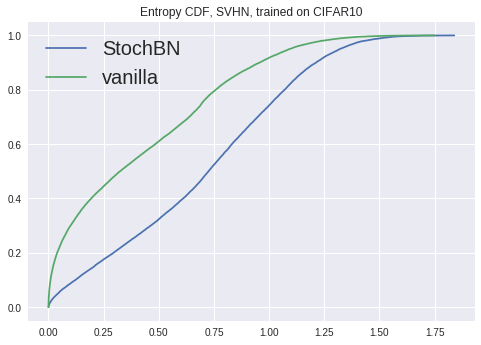

In [89]:
entropy = -np.sum(proba * np.log(proba), 1)
vanilla_entropy = -np.sum(vanilla_proba * np.log(vanilla_proba), 1)

plt.title('Entropy CDF, SVHN, trained on CIFAR10')
plt.plot(sorted(entropy), (np.arange(entropy.shape[0]) + 1.)/ entropy.shape[0], label='StochBN')
plt.plot(sorted(vanilla_entropy), (np.arange(vanilla_entropy.shape[0]) + 1.)/ vanilla_entropy.shape[0],
         label='vanilla')
plt.legend(prop={'size': 20})

# CIFAR-5 uncertainty, VGG11-0.5

In [5]:
def get_proba(dataloader, net, ensemble=1):
    proba = np.zeros((len(dataloader.dataset), 5))
    labels = []
    p = 0
    for img, label in dataloader:
        ens = Ensemble()
        img = Variable(img).cuda()
        for _ in range(ensemble):
            pred = net(img).data.cpu().numpy()
            ens.add_estimator(pred)
        proba[p: p + pred.shape[0]] = ens.get_proba()
        p += pred.shape[0]
        labels += label.tolist()
    return proba, np.array(labels)


def entropy(p):
    return - np.sum(p * np.log(p), 1)

In [6]:
trainloader_rest, testloader_rest = get_dataloader(data='cifar5-rest')
trainloader_first, testloader_first = get_dataloader(data='cifar5')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [9]:
import pandas as pd
entropy_df = pd.DataFrame(columns=['entropy', 'type'])

In [61]:
acc_df = pd.DataFrame(columns=['acc', 'type'])

-----

__Vanilla__

In [4]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
])

def ensemble(net, data, bs, n_infer=50):
    ens = Ensemble()
    acc_data = np.array(list(map(lambda x: transform_test(x).numpy(), data)))
    for _ in range(n_infer):
        logits = np.zeros([acc_data.shape[0], 5])
        perm = np.random.permutation(np.arange(acc_data.shape[0]))

        for i in range(0, len(perm), bs):
            idxs = perm[i: i + bs]
            inputs = Variable(torch.Tensor(acc_data[idxs]).cuda(async=True))
            outputs = net(inputs)
            assert np.allclose(logits[idxs], 0.)
            logits[idxs] = outputs.cpu().data.numpy()

        ens.add_estimator(logits)
    return ens.get_proba()

In [145]:
for bs in [4, 8, 16, 32, 128]:
    net = load_model('vgg-exps/vgg11-0.5-uncertainty-out5/bs{}/vanilla/best_model'.format(bs), print_info=True)
    net.cuda()
    set_bn_mode(net, mode='vanilla')

    net.eval()
    p, l = get_proba(testloader_rest, net)

    t = pd.DataFrame(columns=['entropy', 'type'])
    t['entropy'] = entropy(p)
    t['type'] = 'vanilla eval, bs{}'.format(bs)
    entropy_df = entropy_df.append(t)

    net = load_model('vgg-exps/vgg11-0.5-uncertainty-out5/bs{}/vanilla/best_model'.format(bs), print_info=True)
    net.cuda()
    set_bn_mode(net, mode='StochBN')
    set_MyBN_strategy(net, mean_strategy='batch', var_strategy='batch')
    net.eval()

    ens_p = ensemble(net, testloader_rest.dataset.test_data, bs)
    t = pd.DataFrame(columns=['entropy', 'type'])
    t['entropy'] = entropy(ens_p)
    t['type'] = 'vanilla eval, bs{}, batch avg'.format(bs)
    entropy_df = entropy_df.append(t)

Net validation accuracy = 0.9332
Net validation accuracy = 0.9332


In [160]:
for bs in [4, 8, 16, 32, 128]:
    net = load_model('vgg-exps/vgg11-0.5-uncertainty-out5/bs{}/vanilla/best_model'.format(bs), print_info=True)
    net.cuda()
    set_bn_mode(net, mode='vanilla')

    net.eval()
    p, l = get_proba(testloader_first, net)

    t = pd.DataFrame(columns=['acc', 'type'])
    t['acc'] = [np.mean(p.argmax(1) == l)]
    t['type'] = 'vanilla eval, bs{}'.format(bs)
    acc_df = acc_df.append(t)

    net = load_model('vgg-exps/vgg11-0.5-uncertainty-out5/bs{}/vanilla/best_model'.format(bs), print_info=True)
    net.cuda()
    set_bn_mode(net, mode='StochBN')
    set_MyBN_strategy(net, mean_strategy='batch', var_strategy='batch')
    net.eval()

#     ens_p = ensemble(net, testloader_first.dataset.test_data, bs)
#     t = pd.DataFrame(columns=['acc', 'type'])
#     t['acc'] = [np.mean(ens_p.argmax(1) == testloader_first.dataset.test_labels)]
#     t['type'] = 'vanilla eval, bs{}, batch avg'.format(bs)
#     acc_df = acc_df.append(t)

    ens_p = ensemble(net, testloader_first.dataset.test_data, bs, n_infer=1)
    t = pd.DataFrame(columns=['acc', 'type'])
    t['acc'] = [np.mean(ens_p.argmax(1) == testloader_first.dataset.test_labels)]
    t['type'] = 'vanilla, bs{}, one shot'.format(bs)
    acc_df = acc_df.append(t)

Net validation accuracy = 0.9332
Net validation accuracy = 0.9332
Net validation accuracy = 0.9322
Net validation accuracy = 0.9322
Net validation accuracy = 0.933
Net validation accuracy = 0.933
Net validation accuracy = 0.936
Net validation accuracy = 0.936
Net validation accuracy = 0.9314
Net validation accuracy = 0.9314


----

__Dropout__

In [38]:
net = load_model('vgg-exps/debug/vanilla-dropout/nobn/lr0.001/0.5/best_model', print_info=True)
net.cuda()
set_bn_mode(net, mode='no_bn')

Net validation accuracy = 0.913


In [39]:
net.eval()
for m in net.modules():
    if isinstance(m, nn.Dropout):
        m.train()

p, l = get_proba(testloader_rest, net, ensemble=50)

In [40]:
t = pd.DataFrame(columns=['entropy', 'type'])
t['entropy'] = entropy(p)
t['type'] = 'Dropout 0.5'
entropy_df = entropy_df.append(t)

In [141]:
from itertools import product
do1_grid = [0.3, 0.4, 0.5]
do2_grid = [0.3, 0.4, 0.5]

for do1, do2 in product(do1_grid, do2_grid):
    net = load_model('vgg-exps/vgg11-0.5-uncertainty-out5/dropout-2/lin-lr/{}/{}/best_model'.format(do1, do2),
                     print_info=True)
    set_bn_mode(net, 'vanilla')
    net.cuda()
    net.eval()
    for m in net.modules():
        if isinstance(m, nn.Dropout):
            m.train()

    p, l = get_proba(testloader_rest, net, ensemble=50)

    t = pd.DataFrame(columns=['entropy', 'type'])
    t['entropy'] = entropy(p)
    t['type'] = 'DO BN dr1 {}, dr2 {}, avg'.format(do1, do2)
    entropy_df = entropy_df.append(t)

    net.eval()
    p, l = get_proba(testloader_rest, net, ensemble=1)

    t = pd.DataFrame(columns=['entropy', 'type'])
    t['entropy'] = entropy(p)
    t['type'] = 'DO BN dr1 {}, dr2 {}, eval'.format(do1, do2)
    entropy_df = entropy_df.append(t)

Net validation accuracy = 0.9378
Net validation accuracy = 0.9332
Net validation accuracy = 0.9392
Net validation accuracy = 0.9362
Net validation accuracy = 0.9336
Net validation accuracy = 0.9328
Net validation accuracy = 0.937
Net validation accuracy = 0.9396
Net validation accuracy = 0.9362


In [142]:
do1_grid = [0.3, 0.4, 0.5]
do2_grid = [0.3, 0.4, 0.5]

for do1, do2 in product(do1_grid, do2_grid):
    net = load_model('vgg-exps/vgg11-0.5-uncertainty-out5/dropout-2/lin-lr/{}/{}/best_model'.format(do1, do2),
                     print_info=True)

    net.cuda()
    set_bn_mode(net, mode='vanilla')

    net.eval()
    for m in net.modules():
        if isinstance(m, nn.Dropout):
            m.train()

    p, l = get_proba(testloader_first, net, ensemble=50)

    t = pd.DataFrame(columns=['acc', 'type'])
    t['acc'] = [np.mean(p.argmax(1) == l)]
    t['type'] = 'DO BN dr1 {}, dr2 {}, avg'.format(do1, do2)
    acc_df = acc_df.append(t)

    net.eval()
    p, l = get_proba(testloader_first, net, ensemble=1)
    
    t = pd.DataFrame(columns=['acc', 'type'])
    t['acc'] = [np.mean(p.argmax(1) == l)]
    t['type'] = 'DO BN dr1 {}, dr2 {}, eval'.format(do1, do2)
    acc_df = acc_df.append(t)

Net validation accuracy = 0.9378
Net validation accuracy = 0.9332
Net validation accuracy = 0.9392
Net validation accuracy = 0.9362
Net validation accuracy = 0.9336
Net validation accuracy = 0.9328
Net validation accuracy = 0.937
Net validation accuracy = 0.9396
Net validation accuracy = 0.9362


-----

__StochBN__

In [212]:
bs = 16
for bs in [4, 8, 16, 32, 128]:
    net = load_model('vgg-exps/vgg11-0.5-uncertainty-out5/bs{}/sample_mean/sample_var/one/after/best_model'.format(bs),
                     print_info=True)
    net.cuda()
    set_bn_mode(net, mode='StochBN', update_policy='after', sample_policy='one')

    set_MyBN_strategy(net, mean_strategy='sample', var_strategy='sample')
    net.eval()
    p, l = get_proba(testloader_rest, net, ensemble=50)

    t = pd.DataFrame(columns=['entropy', 'type'])
    t['entropy'] = entropy(p)
    t['type'] = 'StochBN bs{}, avg'.format(bs)
    entropy_df = entropy_df.append(t)

    p, l = get_proba(testloader_rest, net, ensemble=1)

    t = pd.DataFrame(columns=['entropy', 'type'])
    t['entropy'] = entropy(p)
    t['type'] = 'StochBN bs{}, one shot'.format(bs)
    entropy_df = entropy_df.append(t)

    set_MyBN_strategy(net, mean_strategy='running', var_strategy='running')
    p, l = get_proba(testloader_rest, net, ensemble=1)

    t = pd.DataFrame(columns=['entropy', 'type'])
    t['entropy'] = entropy(p)
    t['type'] = 'StochBN bs{}, eval'.format(bs)
    entropy_df = entropy_df.append(t)

Net validation accuracy = 0.9246
Net validation accuracy = 0.9332
Net validation accuracy = 0.931
Net validation accuracy = 0.9338
Net validation accuracy = 0.9294


In [84]:
for bs in [4, 8, 16, 32, 128]:
    net = load_model('vgg-exps/vgg11-0.5-uncertainty-out5/bs{}/sample_mean/sample_var/one/after/best_model'.format(bs),
                     print_info=True)
    net.cuda()
    set_bn_mode(net, mode='StochBN', update_policy='after', sample_policy='bs')

    set_MyBN_strategy(net, mean_strategy='sample', var_strategy='sample')
    net.eval()
    p, l = get_proba(testloader_rest, net, ensemble=50)

    t = pd.DataFrame(columns=['entropy', 'type'])
    t['entropy'] = entropy(p)
    t['type'] = 'StochBN bs{}, sample bs, avg'.format(bs)
    entropy_df = entropy_df.append(t)

    p, l = get_proba(testloader_rest, net, ensemble=1)

    t = pd.DataFrame(columns=['entropy', 'type'])
    t['entropy'] = entropy(p)
    t['type'] = 'StochBN bs{}, sample bs, one shot'.format(bs)
    entropy_df = entropy_df.append(t)

Net validation accuracy = 0.9246
Net validation accuracy = 0.9332


/home/andrew/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
/home/andrew/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in multiply


Net validation accuracy = 0.931
Net validation accuracy = 0.9338
Net validation accuracy = 0.9294


In [73]:
bs = 16
for bs in [4, 8, 16, 32, 128]:
    net = load_model('vgg-exps/vgg11-0.5-uncertainty-out5/bs{}/sample_mean/sample_var/one/after/best_model'.format(bs),
                     print_info=True)
    net.cuda()
    set_bn_mode(net, mode='StochBN', update_policy='after', sample_policy='one')

    set_MyBN_strategy(net, mean_strategy='sample', var_strategy='sample')
    net.eval()
    p, l = get_proba(testloader_first, net, ensemble=50)

    t = pd.DataFrame(columns=['acc', 'type'])
    t['acc'] = [np.mean(p.argmax(1) == l)]
    t['type'] = 'StochBN bs{}, avg'.format(bs)
    acc_df = acc_df.append(t)

    p, l = get_proba(testloader_first, net, ensemble=1)

    t = pd.DataFrame(columns=['acc', 'type'])
    t['acc'] = [np.mean(p.argmax(1) == l)]
    t['type'] = 'StochBN bs{}, one shot'.format(bs)
    acc_df = acc_df.append(t)

Net validation accuracy = 0.9246
Net validation accuracy = 0.9332
Net validation accuracy = 0.931
Net validation accuracy = 0.9338
Net validation accuracy = 0.9294


In [169]:
bs = 16

## calculate accuracy with sample policy -- bs and eval (with running stats mode)
for bs in [4, 8, 16, 32, 128]:
    net = load_model('vgg-exps/vgg11-0.5-uncertainty-out5/bs{}/sample_mean/sample_var/one/after/best_model'.format(bs),
                     print_info=True)
    net.cuda()
    set_bn_mode(net, mode='StochBN', update_policy='after', sample_policy='bs')

    set_MyBN_strategy(net, mean_strategy='sample', var_strategy='sample')
    net.eval()
    p, l = get_proba(testloader_first, net, ensemble=50)

    t = pd.DataFrame(columns=['acc', 'type'])
    t['acc'] = [np.mean(p.argmax(1) == l)]
    t['type'] = 'StochBN bs{}, sample bs, avg'.format(bs)
    acc_df = acc_df.append(t)

    p, l = get_proba(testloader_first, net, ensemble=1)

    t = pd.DataFrame(columns=['acc', 'type'])
    t['acc'] = [np.mean(p.argmax(1) == l)]
    t['type'] = 'StochBN bs{}, sample bs, one shot'.format(bs)
    acc_df = acc_df.append(t)
    
    set_MyBN_strategy(net, mean_strategy='running', var_strategy='running')
    p, l = get_proba(testloader_first, net, ensemble=1)
    t = pd.DataFrame(columns=['acc', 'type'])
    t['acc'] = [np.mean(p.argmax(1) == l)]
    t['type'] = 'StochBN bs{}, eval'.format(bs)
    acc_df = acc_df.append(t)
    
    set_MyBN_strategy(net, mean_strategy='running', var_strategy='running-mean')
    p, l = get_proba(testloader_first, net, ensemble=1)
    t = pd.DataFrame(columns=['acc', 'type'])
    t['acc'] = [np.mean(p.argmax(1) == l)]
    t['type'] = 'StochBN bs{}, eval, correct var mean'.format(bs)
    acc_df = acc_df.append(t)

Net validation accuracy = 0.9246
Net validation accuracy = 0.9332
Net validation accuracy = 0.931
Net validation accuracy = 0.9338
Net validation accuracy = 0.9294


In [224]:
bs = 16

## calculate accuracy with sample policy -- bs and eval (with running stats mode)
## Evaluating model from last epoch
for bs in [4, 8, 16, 32, 128]:
    net = load_model('vgg-exps/vgg11-0.5-uncertainty-out5/bs{}/sample_mean/sample_var/one/after/model'.format(bs),
                     print_info=True)
    net.cuda()
    set_bn_mode(net, mode='StochBN', update_policy='after', sample_policy='bs')

    set_MyBN_strategy(net, mean_strategy='sample', var_strategy='sample')
    net.eval()
    p, l = get_proba(testloader_first, net, ensemble=50)

    t = pd.DataFrame(columns=['acc', 'type'])
    t['acc'] = [np.mean(p.argmax(1) == l)]
    t['type'] = 'StochBN bs{}, sample bs, avg, last model'.format(bs)
    acc_df = acc_df.append(t)

    p, l = get_proba(testloader_first, net, ensemble=1)

    t = pd.DataFrame(columns=['acc', 'type'])
    t['acc'] = [np.mean(p.argmax(1) == l)]
    t['type'] = 'StochBN bs{}, sample bs, one shot, last model'.format(bs)
    acc_df = acc_df.append(t)
    
    set_MyBN_strategy(net, mean_strategy='running', var_strategy='running')
    p, l = get_proba(testloader_first, net, ensemble=1)
    t = pd.DataFrame(columns=['acc', 'type'])
    t['acc'] = [np.mean(p.argmax(1) == l)]
    t['type'] = 'StochBN bs{}, eval, last model'.format(bs)
    acc_df = acc_df.append(t)
    
    set_MyBN_strategy(net, mean_strategy='running', var_strategy='running-mean')
    p, l = get_proba(testloader_first, net, ensemble=1)
    t = pd.DataFrame(columns=['acc', 'type'])
    t['acc'] = [np.mean(p.argmax(1) == l)]
    t['type'] = 'StochBN bs{}, eval, correct var mean, last model'.format(bs)
    acc_df = acc_df.append(t)

Net validation accuracy = 0.9092
Net validation accuracy = 0.9194
Net validation accuracy = 0.9254
Net validation accuracy = 0.9338
Net validation accuracy = 0.9162


In [230]:
bs = 16

## Evaluating model from last epoch
for bs in [4, 8, 16, 32, 128]:
    net = load_model('vgg-exps/vgg11-0.5-uncertainty-out5/bs{}/sample_mean/sample_var/one/after/model'.format(bs),
                     print_info=True)
    net.cuda()
    set_bn_mode(net, mode='StochBN', update_policy='after', sample_policy='bs')

    set_MyBN_strategy(net, mean_strategy='sample', var_strategy='sample')
    net.eval()
    p, l = get_proba(testloader_rest, net, ensemble=50)

    t = pd.DataFrame(columns=['entropy', 'type'])
    t['entropy'] = entropy(p)
    t['type'] = 'StochBN bs{}, avg, last model'.format(bs)
    entropy_df = entropy_df.append(t)

    p, l = get_proba(testloader_rest, net, ensemble=1)

    t = pd.DataFrame(columns=['entropy', 'type'])
    t['entropy'] = entropy(p)
    t['type'] = 'StochBN bs{}, one shot, last model'.format(bs)
    entropy_df = entropy_df.append(t)

    set_MyBN_strategy(net, mean_strategy='running', var_strategy='running')
    p, l = get_proba(testloader_rest, net, ensemble=1)

    t = pd.DataFrame(columns=['entropy', 'type'])
    t['entropy'] = entropy(p)
    t['type'] = 'StochBN bs{}, eval, last model'.format(bs)
    entropy_df = entropy_df.append(t)

Net validation accuracy = 0.9092
Net validation accuracy = 0.9194
Net validation accuracy = 0.9254
Net validation accuracy = 0.9338
Net validation accuracy = 0.9162


In [85]:
bs = 16
for bs in [4, 8, 16, 32, 128]:
    net = load_model('vgg-exps/vgg11-0.5-uncertainty-out5/bs{}/sample_mean/sample_var/one/after/best_model'.format(bs),
                     print_info=True)
    net.cuda()
    set_bn_mode(net, mode='StochBN', update_policy='after', sample_policy='bs')

    set_MyBN_strategy(net, mean_strategy='sample', var_strategy='sample')
    net.eval()
    p, l = get_proba(testloader_first, net, ensemble=50)

    t = pd.DataFrame(columns=['acc', 'type'])
    t['acc'] = [np.mean(p.argmax(1) == l)]
    t['type'] = 'StochBN bs{}, sample bs, avg'.format(bs)
    acc_df = acc_df.append(t)

    p, l = get_proba(testloader_first, net, ensemble=1)

    t = pd.DataFrame(columns=['acc', 'type'])
    t['acc'] = [np.mean(p.argmax(1) == l)]
    t['type'] = 'StochBN bs{}, sample bs, one shot'.format(bs)
    acc_df = acc_df.append(t)

Net validation accuracy = 0.9246
Net validation accuracy = 0.9332
Net validation accuracy = 0.931
Net validation accuracy = 0.9338
Net validation accuracy = 0.9294


-----

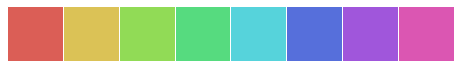

In [12]:
colors = sns.hls_palette(n_colors=len(entropy_df['type'].unique()))
sns.palplot(colors)

## One model VS Ensemble

###  StochBN

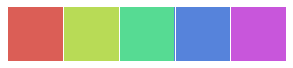

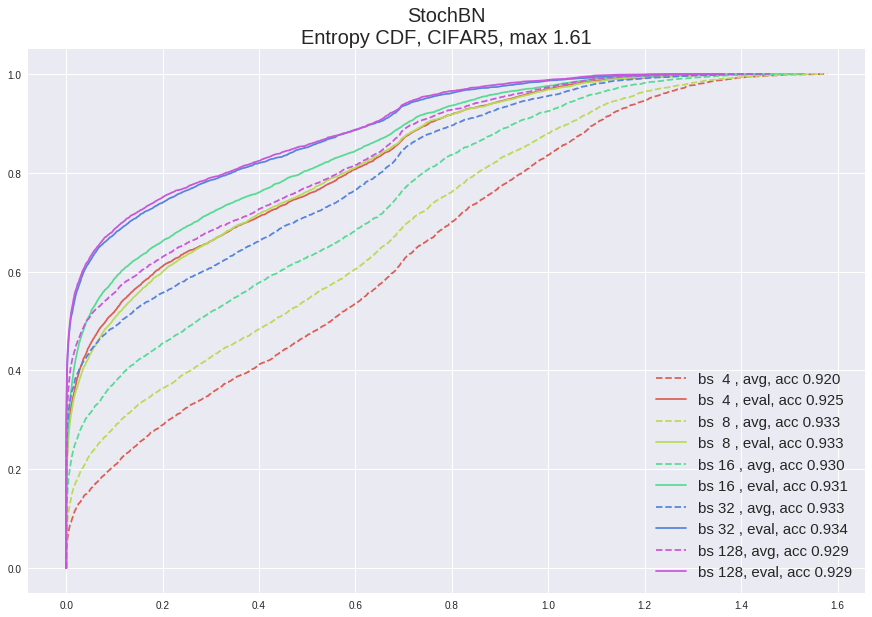

In [214]:
bs_grid = [4, 8, 16, 32, 128]
colors = sns.hls_palette(n_colors=len(bs_grid))
sns.palplot(colors)

plt.figure(figsize=(15, 10))
plt.title('StochBN\nEntropy CDF, CIFAR5, max 1.61', size=20)
for bs, c in zip(bs_grid, colors):
    mtype = 'StochBN bs{}, avg'.format(bs)
    t = entropy_df[entropy_df['type'] == mtype]
    assert len(t) == 5000
    ent = t['entropy']
    plt.plot(np.sort(ent), (np.arange(len(ent)) + 1.) / len(ent),
             label='bs {:^3}, avg, acc {:.3f}'.format(bs, acc_df[acc_df['type'] == mtype]['acc'].values[0]),
             c=c, ls='--')

    mtype = 'StochBN bs{}, eval'.format(bs)
    t = entropy_df[entropy_df['type'] == mtype]
    assert len(t) == 5000
    ent = t['entropy']
    plt.plot(np.sort(ent), (np.arange(len(ent)) + 1.) / len(ent),
             label='bs {:^3}, eval, acc {:.3f}'.format(bs, acc_df[acc_df['type'] == mtype]['acc'].values[0]), c=c)


plt.legend(prop={'size': 15})
plt.savefig('figure/uncertainty_stochbn', dpi=300)

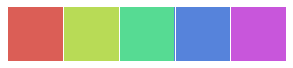

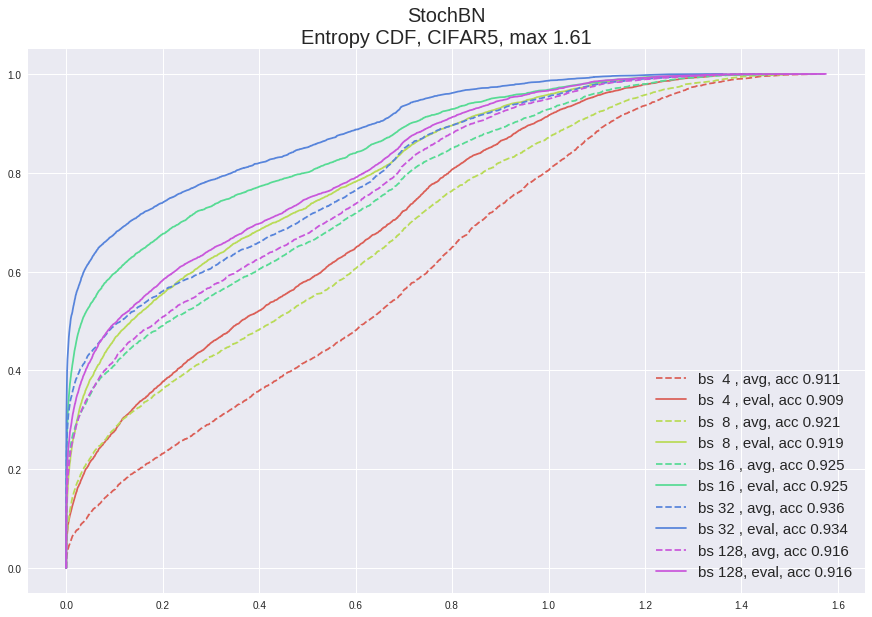

In [237]:
bs_grid = [4, 8, 16, 32, 128]
colors = sns.hls_palette(n_colors=len(bs_grid))
sns.palplot(colors)

plt.figure(figsize=(15, 10))
plt.title('StochBN\nEntropy CDF, CIFAR5, max 1.61', size=20)
for bs, c in zip(bs_grid, colors):
    mtype = 'StochBN bs{}, avg, last model'.format(bs)
    mtype_acc = 'StochBN bs{}, sample bs, avg, last model'.format(bs)  

    t = entropy_df[entropy_df['type'] == mtype]
    assert len(t) == 5000
    ent = t['entropy']
    plt.plot(np.sort(ent), (np.arange(len(ent)) + 1.) / len(ent),
             label='bs {:^3}, avg, acc {:.3f}'.format(bs, acc_df[acc_df['type'] == mtype_acc]['acc'].values[0]),
             c=c, ls='--')

    mtype = 'StochBN bs{}, eval, last model'.format(bs)
    mtype_acc = 'StochBN bs{}, eval, last model'.format(bs)  

    t = entropy_df[entropy_df['type'] == mtype]
    assert len(t) == 5000
    ent = t['entropy']
    plt.plot(np.sort(ent), (np.arange(len(ent)) + 1.) / len(ent),
             label='bs {:^3}, eval, acc {:.3f}'.format(bs, acc_df[acc_df['type'] == mtype_acc]['acc'].values[0]), c=c)


plt.legend(prop={'size': 15})
# plt.savefig('figure/uncertainty_stochbn_last-epoch', dpi=300)

### Vanilla

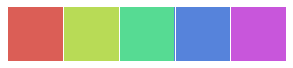

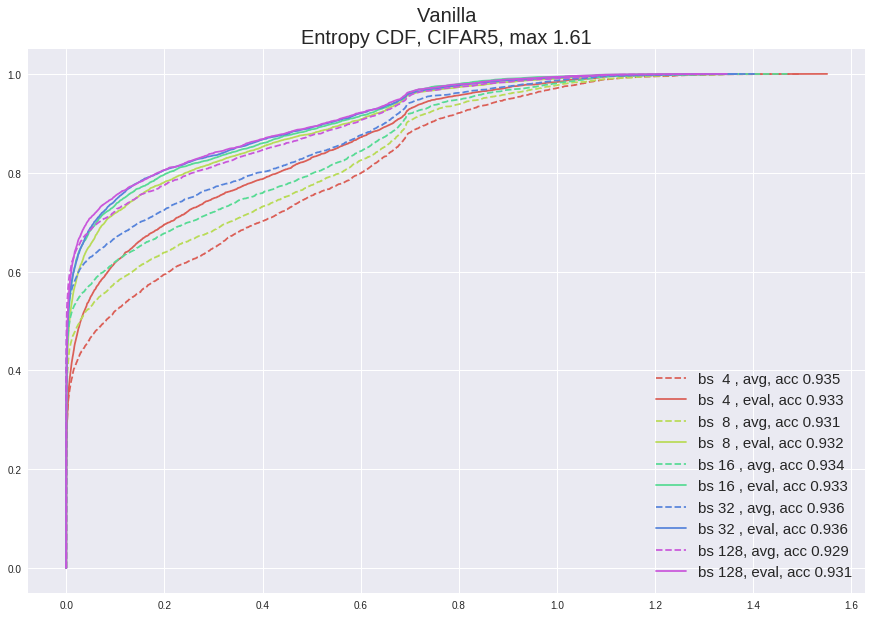

In [215]:
bs_grid = [4,8, 16, 32, 128]
colors = sns.hls_palette(n_colors=len(bs_grid))
sns.palplot(colors)

plt.figure(figsize=(15, 10))
plt.title('Vanilla\nEntropy CDF, CIFAR5, max 1.61', size=20)
for bs, c in zip(bs_grid, colors):
    mtype = 'vanilla eval, bs{}, batch avg'.format(bs)
    t = entropy_df[entropy_df['type'] == mtype]
    assert len(t) == 5000
    ent = t['entropy']
    plt.plot(np.sort(ent), (np.arange(len(ent)) + 1.) / len(ent),
             label='bs {:^3}, avg, acc {:.3f}'.format(bs, acc_df[acc_df['type'] == mtype]['acc'].values[0]),
             c=c, ls='--')

    mtype = 'vanilla eval, bs{}'.format(bs)
    t = entropy_df[entropy_df['type'] == mtype]
    assert len(t) == 5000
    ent = t['entropy']
    plt.plot(np.sort(ent), (np.arange(len(ent)) + 1.) / len(ent),
             label='bs {:^3}, eval, acc {:.3f}'.format(bs, acc_df[acc_df['type'] == mtype]['acc'].values[0]),
             c=c)


plt.legend(prop={'size': 15})
plt.savefig('figure/uncertainty_vanilla', dpi=300)

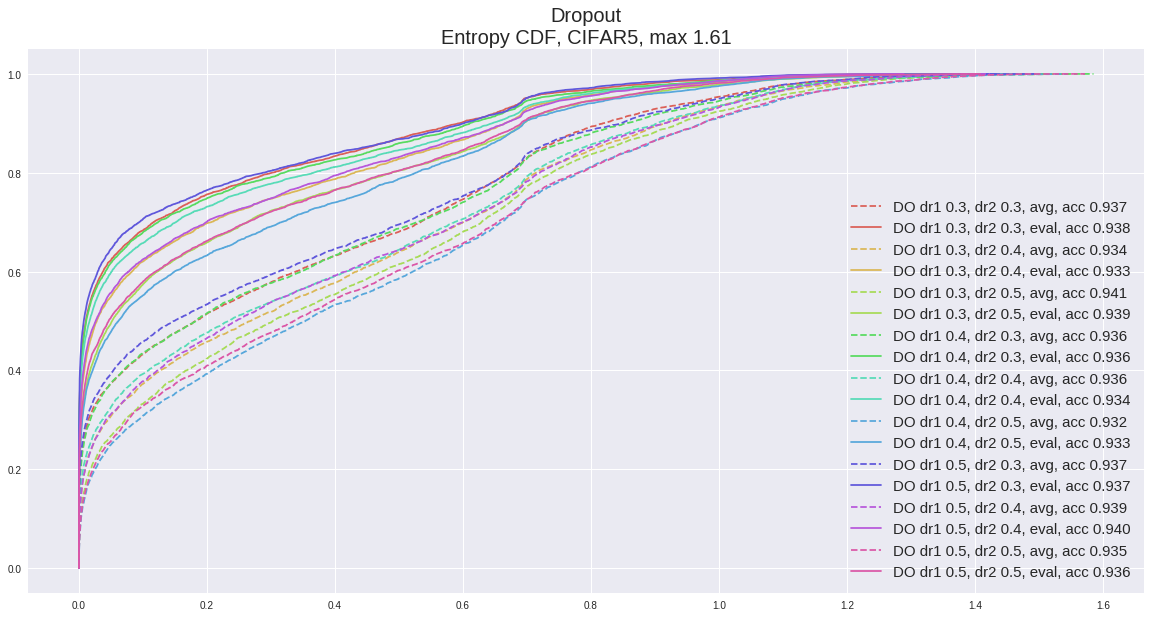

In [144]:
plt.figure(figsize=(20, 10))
plt.title('Dropout\nEntropy CDF, CIFAR5, max 1.61', size=20)

do1_grid = [0.3, 0.4, 0.5]
do2_grid = [0.3, 0.4, 0.5]
colors = sns.hls_palette(n_colors=len(do1_grid) * len(do2_grid))

for c, [do1, do2] in zip(colors, product(do1_grid, do2_grid)):
    mtype = 'DO BN dr1 {}, dr2 {}, avg'.format(do1, do2)
    t = entropy_df[entropy_df['type'] == mtype]
    assert len(t) == 5000
    ent = t['entropy']
    plt.plot(np.sort(ent), (np.arange(len(ent)) + 1.) / len(ent),
             label='DO dr1 {}, dr2 {}, avg, acc {:.3f}'.format(do1, do2, acc_df[acc_df['type'] == mtype]['acc'].values[0]),
             c=c, ls='--')

    mtype = 'DO BN dr1 {}, dr2 {}, eval'.format(do1, do2)
    t = entropy_df[entropy_df['type'] == mtype]
    assert len(t) == 5000
    ent = t['entropy']
    plt.plot(np.sort(ent), (np.arange(len(ent)) + 1.) / len(ent),
             label='DO dr1 {}, dr2 {}, eval, acc {:.3f}'.format(do1, do2, acc_df[acc_df['type'] == mtype]['acc'].values[0]),
             c=c)


plt.legend(prop={'size': 15})
# plt.savefig('figure/uncertainty_vanilla', dpi=300)

### StochBN sample BS vs ONE

Sample either one mean (variance) for batch or mean for each element in batch. 

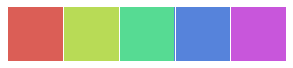

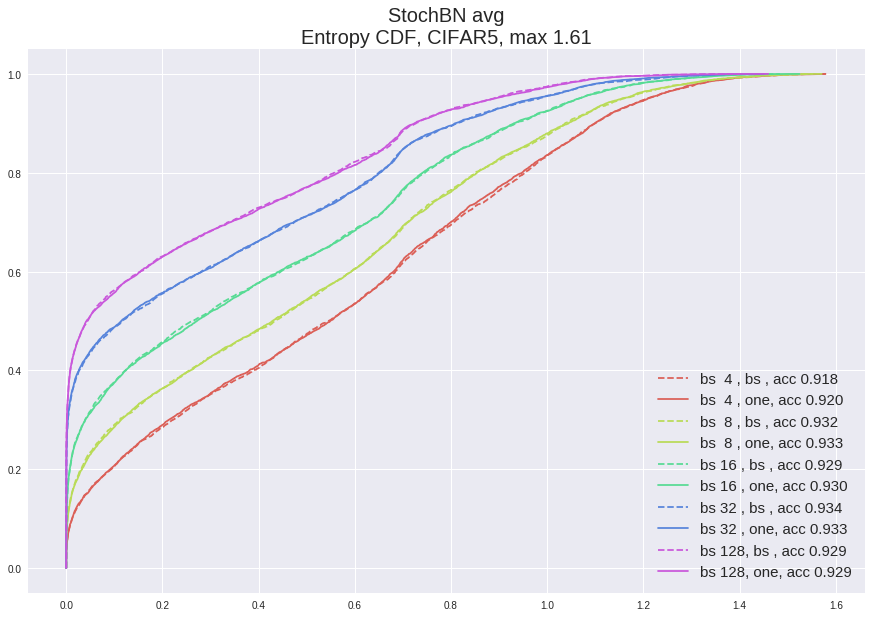

In [87]:
bs_grid = [4, 8, 16, 32, 128]
colors = sns.hls_palette(n_colors=len(bs_grid))
sns.palplot(colors)

plt.figure(figsize=(15, 10))
plt.title('StochBN avg\nEntropy CDF, CIFAR5, max 1.61', size=20)
for bs, c in zip(bs_grid, colors):
    mtype = 'StochBN bs{}, sample bs, avg'.format(bs)
    t = entropy_df[entropy_df['type'] == mtype]
    assert len(t) == 5000
    ent = t['entropy']
    plt.plot(np.sort(ent), (np.arange(len(ent)) + 1.) / len(ent),
             label='bs {:^3}, bs , acc {:.3f}'.format(bs, acc_df[acc_df['type'] == mtype]['acc'].values[0]),
             c=c, ls='--')

    mtype = 'StochBN bs{}, avg'.format(bs)
    t = entropy_df[entropy_df['type'] == mtype]
    assert len(t) == 5000
    ent = t['entropy']
    plt.plot(np.sort(ent), (np.arange(len(ent)) + 1.) / len(ent),
             label='bs {:^3}, one, acc {:.3f}'.format(bs, acc_df[acc_df['type'] == mtype]['acc'].values[0]), c=c)


plt.legend(prop={'size': 15})
# plt.savefig('figure/uncertainty_stochbn', dpi=300)

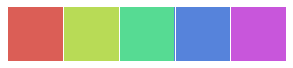

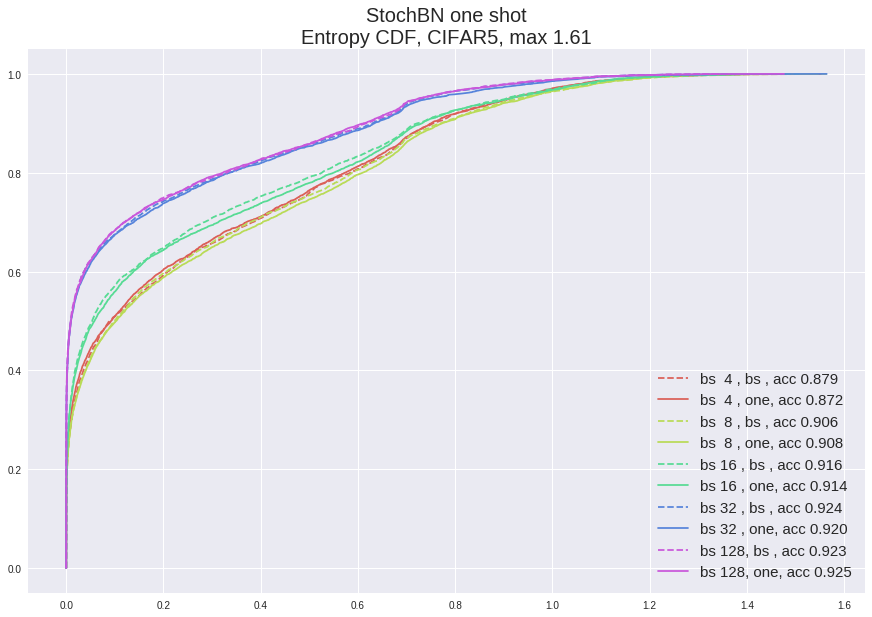

In [88]:
bs_grid = [4, 8, 16, 32, 128]
colors = sns.hls_palette(n_colors=len(bs_grid))
sns.palplot(colors)

plt.figure(figsize=(15, 10))
plt.title('StochBN one shot\nEntropy CDF, CIFAR5, max 1.61', size=20)
for bs, c in zip(bs_grid, colors):
    mtype = 'StochBN bs{}, sample bs, one shot'.format(bs)
    t = entropy_df[entropy_df['type'] == mtype]
    assert len(t) == 5000
    ent = t['entropy']
    plt.plot(np.sort(ent), (np.arange(len(ent)) + 1.) / len(ent),
             label='bs {:^3}, bs , acc {:.3f}'.format(bs, acc_df[acc_df['type'] == mtype]['acc'].values[0]),
             c=c, ls='--')

    mtype = 'StochBN bs{}, one shot'.format(bs)
    t = entropy_df[entropy_df['type'] == mtype]
    assert len(t) == 5000
    ent = t['entropy']
    plt.plot(np.sort(ent), (np.arange(len(ent)) + 1.) / len(ent),
             label='bs {:^3}, one, acc {:.3f}'.format(bs, acc_df[acc_df['type'] == mtype]['acc'].values[0]), c=c)


plt.legend(prop={'size': 15})
# plt.savefig('figure/uncertainty_stochbn', dpi=300)

### DO StochBN Vanilla

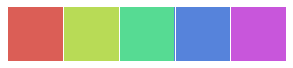

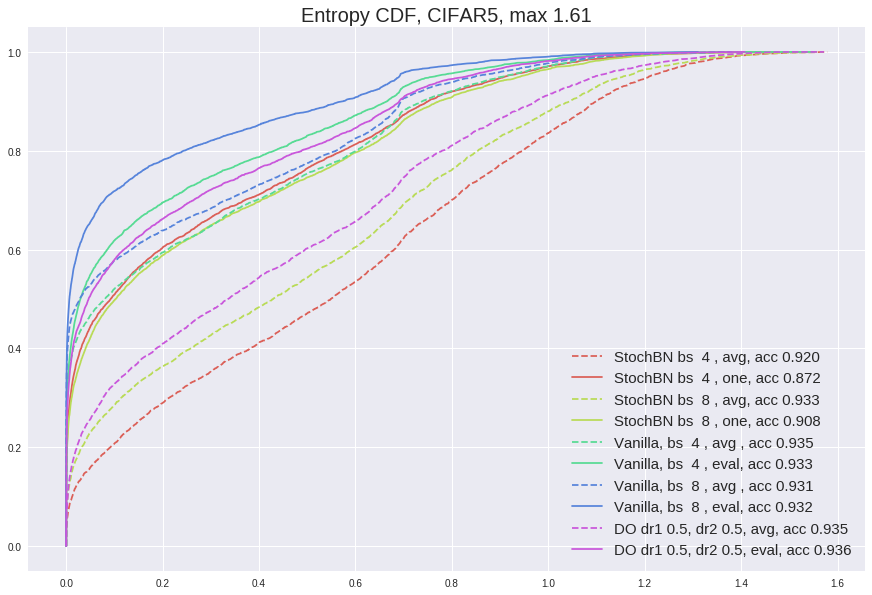

In [149]:
bs_grid = [4, 8]
colors = sns.hls_palette(n_colors=5)
sns.palplot(colors)

plt.figure(figsize=(15, 10))
plt.title('Entropy CDF, CIFAR5, max 1.61', size=20)
for bs, c in zip(bs_grid, colors):
    mtype = 'StochBN bs{}, avg'.format(bs)
    t = entropy_df[entropy_df['type'] == mtype]
    assert len(t) == 5000
    ent = t['entropy']
    plt.plot(np.sort(ent), (np.arange(len(ent)) + 1.) / len(ent),
             label='StochBN bs {:^3}, avg, acc {:.3f}'.format(bs, acc_df[acc_df['type'] == mtype]['acc'].values[0]),
             c=c, ls='--')

    mtype = 'StochBN bs{}, one shot'.format(bs)
    t = entropy_df[entropy_df['type'] == mtype]
    assert len(t) == 5000
    ent = t['entropy']
    plt.plot(np.sort(ent), (np.arange(len(ent)) + 1.) / len(ent),
             label='StochBN bs {:^3}, one, acc {:.3f}'.format(bs, acc_df[acc_df['type'] == mtype]['acc'].values[0]), c=c)


# plt.legend(prop={'size': 15})
# plt.savefig('figure/uncertainty_stochbn', dpi=300)

#----

bs_grid = [4, 8]
# colors = sns.hls_palette(n_colors=len(bs_grid))
# sns.palplot(colors)

# plt.figure(figsize=(15, 10))
# plt.title('Vanilla\nEntropy CDF, CIFAR5, max 1.61', size=20)
for bs, c in zip(bs_grid, colors[2:]):
    mtype = 'vanilla eval, bs{}, batch avg'.format(bs)
    t = entropy_df[entropy_df['type'] == mtype]
    assert len(t) == 5000
    ent = t['entropy']
    plt.plot(np.sort(ent), (np.arange(len(ent)) + 1.) / len(ent),
             label='Vanilla, bs {:^3}, avg , acc {:.3f}'.format(bs, acc_df[acc_df['type'] == mtype]['acc'].values[0]),
             c=c, ls='--')

    mtype = 'vanilla eval, bs{}'.format(bs)
    t = entropy_df[entropy_df['type'] == mtype]
    assert len(t) == 5000
    ent = t['entropy']
    plt.plot(np.sort(ent), (np.arange(len(ent)) + 1.) / len(ent),
             label='Vanilla, bs {:^3}, eval, acc {:.3f}'.format(bs, acc_df[acc_df['type'] == mtype]['acc'].values[0]),
             c=c)


plt.legend(prop={'size': 15})
# plt.savefig('figure/uncertainty_vanilla', dpi=300)


#-----


# plt.figure(figsize=(20, 10))
# plt.title('Dropout\nEntropy CDF, CIFAR5, max 1.61', size=20)

do1_grid = [0.3, 0.4, 0.5][2:]
do2_grid = [0.3, 0.4, 0.5][2:]
# colors = sns.hls_palette(n_colors=len(do1_grid) * len(do2_grid))

for c, [do1, do2] in zip(colors[4:], product(do1_grid, do2_grid)):
    mtype = 'DO BN dr1 {}, dr2 {}, avg'.format(do1, do2)
    t = entropy_df[entropy_df['type'] == mtype]
    assert len(t) == 5000
    ent = t['entropy']
    plt.plot(np.sort(ent), (np.arange(len(ent)) + 1.) / len(ent),
             label='DO dr1 {}, dr2 {}, avg, acc {:.3f}'.format(do1, do2, acc_df[acc_df['type'] == mtype]['acc'].values[0]),
             c=c, ls='--')

    mtype = 'DO BN dr1 {}, dr2 {}, eval'.format(do1, do2)
    t = entropy_df[entropy_df['type'] == mtype]
    assert len(t) == 5000
    ent = t['entropy']
    plt.plot(np.sort(ent), (np.arange(len(ent)) + 1.) / len(ent),
             label='DO dr1 {}, dr2 {}, eval, acc {:.3f}'.format(do1, do2, acc_df[acc_df['type'] == mtype]['acc'].values[0]),
             c=c)


plt.legend(prop={'size': 15})# plt.savefig('figure/uncertainty_vanilla', dpi=300

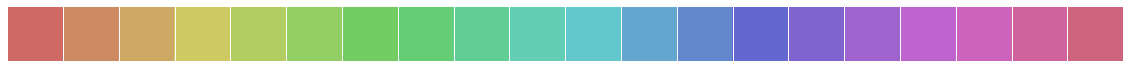

In [217]:
colors = sns.color_palette(palette='hls', n_colors=20, desat=.8)
sns.palplot(colors)

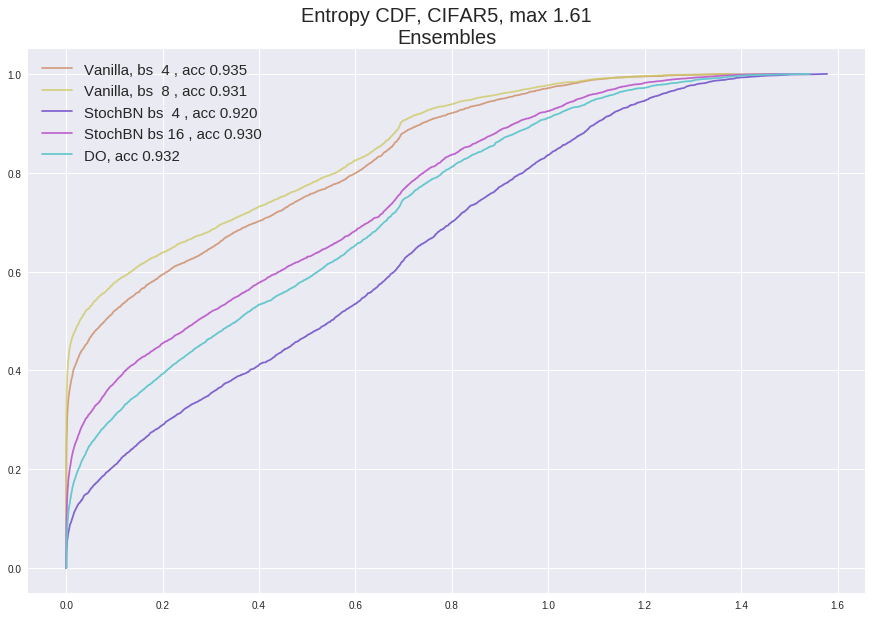

In [225]:
plt.figure(figsize=(15, 10))
plt.title('Entropy CDF, CIFAR5, max 1.61\nEnsembles', size=20)

bs = 4
mtype = 'vanilla eval, bs{}, batch avg'.format(bs)
t = entropy_df[entropy_df['type'] == mtype]
assert len(t) == 5000
ent = t['entropy']
plt.plot(np.sort(ent), (np.arange(len(ent)) + 1.) / len(ent),
         label='Vanilla, bs {:^3}, acc {:.3f}'.format(bs, acc_df[acc_df['type'] == mtype]['acc'].values[0]),
         alpha=.8, c=colors[1])

bs = 8
mtype = 'vanilla eval, bs{}, batch avg'.format(bs)
t = entropy_df[entropy_df['type'] == mtype]
assert len(t) == 5000
ent = t['entropy']
plt.plot(np.sort(ent), (np.arange(len(ent)) + 1.) / len(ent),
         label='Vanilla, bs {:^3}, acc {:.3f}'.format(bs, acc_df[acc_df['type'] == mtype]['acc'].values[0]),
         alpha=.8, c=colors[3])

bs = 4
mtype = 'StochBN bs{}, avg'.format(bs)
t = entropy_df[entropy_df['type'] == mtype]
assert len(t) == 5000
ent = t['entropy']
plt.plot(np.sort(ent), (np.arange(len(ent)) + 1.) / len(ent),
         label='StochBN bs {:^3}, acc {:.3f}'.format(bs, acc_df[acc_df['type'] == mtype]['acc'].values[0]),
         c=colors[14])

bs = 16
mtype = 'StochBN bs{}, avg'.format(bs)
t = entropy_df[entropy_df['type'] == mtype]
assert len(t) == 5000
ent = t['entropy']
plt.plot(np.sort(ent), (np.arange(len(ent)) + 1.) / len(ent),
         label='StochBN bs {:^3}, acc {:.3f}'.format(bs, acc_df[acc_df['type'] == mtype]['acc'].values[0]),
         c=colors[16])

do1, do2 = 0.4, 0.5
mtype = 'DO BN dr1 {}, dr2 {}, avg'.format(do1, do2)
t = entropy_df[entropy_df['type'] == mtype]
assert len(t) == 5000
ent = t['entropy']
plt.plot(np.sort(ent), (np.arange(len(ent)) + 1.) / len(ent),
         label='DO, acc {:.3f}'.format(acc_df[acc_df['type'] == mtype]['acc'].values[0]),
         c=colors[10])




plt.legend(prop={'size': 15});
# plt.savefig('figure/ensembles_entropy_comp', dpi=300)